In [235]:
import numpy as np
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools, algorithms
import matplotlib.animation as animation

In [236]:
class GaussianSurface:
    def __init__(self, num_peaks, xy_bounds=((-20, 20), (-20, 20)), amplitude_bounds=(1.0, 3.0), sigma=6.0, seed=None):
        self.num_peaks = num_peaks
        self.xy_bounds = xy_bounds
        self.amplitude_bounds = amplitude_bounds
        self.sigma = sigma
        self.seed = seed
        self.peaks, self.amplitudes = self._generate_peaks()

    def _generate_peaks(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        x_peaks = np.random.uniform(self.xy_bounds[0][0], self.xy_bounds[0][1], self.num_peaks)
        y_peaks = np.random.uniform(self.xy_bounds[1][0], self.xy_bounds[1][1], self.num_peaks)
        amplitudes = np.random.uniform(self.amplitude_bounds[0], self.amplitude_bounds[1], self.num_peaks)
        return np.column_stack((x_peaks, y_peaks)), amplitudes

    def evaluate(self, X, Y):
        Z = np.zeros_like(X)
        for (px, py), amp in zip(self.peaks, self.amplitudes):
            Z += amp * np.exp(-((X - px) ** 2 + (Y - py) ** 2) / (2 * self.sigma ** 2))
        return Z

    def evaluate_point(self, x, y):
        z = 0
        for (px, py), amp in zip(self.peaks, self.amplitudes):
            z += amp * np.exp(-((x - px) ** 2 + (y - py) ** 2) / (2 * self.sigma ** 2))
        return z

In [237]:
class GeneticAlgorithmDEAP:
    def __init__(
        self,
        surface,
        bounds=[(-20, 20), (-20, 20)],
        step_sizes=[2.0, 2.0],
        cxpb=0.5,
        mutpb=0.2,
        seed=None
    ):
        self.surface = surface
        self.bounds = bounds
        self.step_sizes = step_sizes
        self.population_size, self.generations = suggest_ga_params(bounds, step_sizes)
        self.cxpb = cxpb
        self.mutpb = mutpb
        self.population_snapshots = []
        self.fitness_history = []
        self.best_history = []
        self.converged_generation = None
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        self._setup_deap()

    def _fitness_function(self, individual):
        x, y = individual
        return (-self.surface.evaluate_point(x, y),)

    @staticmethod
    def make_grid_attr(low, high, step):
        def attr():
            return random.randrange(int(low / step), int(high / step) + 1) * step
        return attr

    @staticmethod
    def grid_mutation(individual, step_sizes, bounds):
        for i in range(len(individual)):
            if random.random() < 0.2:
                direction = random.choice([-1, 1])
                new_val = individual[i] + direction * step_sizes[i]
                # Clamp to bounds and snap to grid
                new_val = max(bounds[i][0], min(bounds[i][1], new_val))
                # Snap to grid
                new_val = round((new_val - bounds[i][0]) / step_sizes[i]) * step_sizes[i] + bounds[i][0]
                individual[i] = new_val
        return (individual,)

    def suggest_ga_params(self, max_population=1000, max_generations=500):
        # Calculate number of possible values for each parameter
        num_values = [
            int((high - low) / step) + 1
            for (low, high), step in zip(self.bounds, self.step_sizes)
        ]
        total_combinations = np.prod(num_values)
        # Heuristic: population size is sqrt of total combinations, capped
        population_size = min(int(np.sqrt(total_combinations)), max_population)
        # Heuristic: generations is 2 * population size, capped
        generations = min(2 * population_size, max_generations)
        return population_size, generations

    def _setup_deap(self):
        if not hasattr(creator, "FitnessMin"):
            creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        if not hasattr(creator, "Individual"):
            creator.create("Individual", list, fitness=creator.FitnessMin)
        self.toolbox = base.Toolbox()
        # Register per-parameter grid attribute
        self.toolbox.register("attr_x", self.make_grid_attr(self.bounds[0][0], self.bounds[0][1], self.step_sizes[0]))
        self.toolbox.register("attr_y", self.make_grid_attr(self.bounds[1][0], self.bounds[1][1], self.step_sizes[1]))
        self.toolbox.register("individual", tools.initCycle, creator.Individual, (self.toolbox.attr_x, self.toolbox.attr_y), n=1)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("evaluate", self._fitness_function)
        self.toolbox.register("mate", tools.cxUniform, indpb=0.5)
        # Use custom grid mutation
        self.toolbox.register("mutate", self.grid_mutation, step_sizes=self.step_sizes, bounds=self.bounds)
        self.toolbox.register("select", tools.selTournament, tournsize=3)

    def run(self):
        pop = self.toolbox.population(n=self.population_size)
        hof = tools.HallOfFame(1)
        for gen in range(self.generations):
            offspring = algorithms.varAnd(pop, self.toolbox, cxpb=self.cxpb, mutpb=self.mutpb)
            fits = list(map(self.toolbox.evaluate, offspring))
            for ind, fit in zip(offspring, fits):
                ind.fitness.values = fit
            pop = self.toolbox.select(offspring, k=len(pop))
            hof.update(pop)
            fitnesses = [ind.fitness.values[0] for ind in pop]
            self.fitness_history.append(np.mean(fitnesses))
            self.best_history.append(np.min(fitnesses))
            self.population_snapshots.append(np.array([ind[:] for ind in pop]))
            if np.std(fitnesses) < 1e-3:
                self.converged_generation = gen + 1
                break
        self.best_individual = hof[0]
        if self.converged_generation is None:
            self.converged_generation = self.generations
        return hof[0]
        
    def animate_population(self, X, Y, Z, save_path=None):
        # Dynamically scale the figure size based on bounds
        x_range = self.bounds[0][1] - self.bounds[0][0]
        y_range = self.bounds[1][1] - self.bounds[1][0]
        aspect_ratio = x_range / y_range if y_range != 0 else 1
        fig_width = 10
        fig_height = max(5, fig_width / aspect_ratio)

        fig, ax = plt.subplots(figsize=(fig_width, fig_height))
        contour = ax.contourf(X, Y, Z, levels=25, cmap='terrain')
        plt.colorbar(contour, ax=ax, label='Function Value')
        scat = ax.scatter([], [], color='red', s=20, label='Population')
        ax.set_xlim(self.bounds[0][0], self.bounds[0][1])
        ax.set_ylim(self.bounds[1][0], self.bounds[1][1])
        ax.set_aspect('auto')  # or 'equal' for square grid
        ax.legend()
        def update(frame):
            data = self.population_snapshots[frame]
            scat.set_offsets(data)
            ax.set_title(f'Generation {frame+1}')
            return scat,
        ani = animation.FuncAnimation(fig, update, frames=len(self.population_snapshots), interval=200, blit=True)
        if save_path:
            ani.save(save_path, writer='pillow', fps=2)
        else:
            plt.show()

    def animate_fitness_trend(self, save_path=None):
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.set_xlim(0, len(self.fitness_history))
        ax.set_ylim(min(self.best_history) * 1.1, max(self.fitness_history) * 1.1)
        line_avg, = ax.plot([], [], 'b-', label='Average Fitness')
        line_best, = ax.plot([], [], 'r-', label='Best Fitness')
        ax.set_xlabel('Generation')
        ax.set_ylabel('Fitness')
        ax.set_title('Fitness Trend Over Generations')
        ax.legend()
        ax.grid(True)
        def update(frame):
            line_avg.set_data(range(frame+1), self.fitness_history[:frame+1])
            line_best.set_data(range(frame+1), self.best_history[:frame+1])
            return line_avg, line_best
        ani = animation.FuncAnimation(fig, update, frames=len(self.fitness_history), interval=200, blit=True)
        if save_path:
            ani.save(save_path, writer='pillow', fps=5)
        else:
            plt.show()

In [238]:
# --- Parameters ---
num_peaks = 5
xy_bounds = [(-40, 40), (-20, 20)]  # Bound range for parameters
amplitude_bounds = [1.0, 3.0]  # Amplitude bounds for peaks
step_sizes = [0.5, 0.3]  # Step sizes for each parameter
sigma = 6.0

# --- Create Gaussian Surface ---
surface = GaussianSurface(
    num_peaks, 
    xy_bounds, 
    amplitude_bounds=amplitude_bounds, 
    sigma=sigma, 
    seed=42
)

# --- Create grid for plotting ---
x = np.linspace(xy_bounds[0][0], xy_bounds[0][1], 400)
y = np.linspace(xy_bounds[1][0], xy_bounds[1][1], 400)
X, Y = np.meshgrid(x, y)
Z = surface.evaluate(X, Y)

Best solution (global minima found): [36.0, -17.6]
Function value at best solution: 2.9394465277655075
Converged in 11 generations.


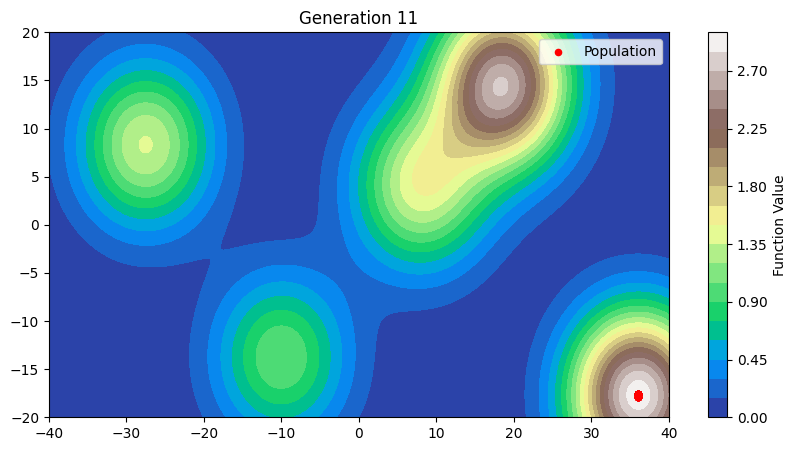

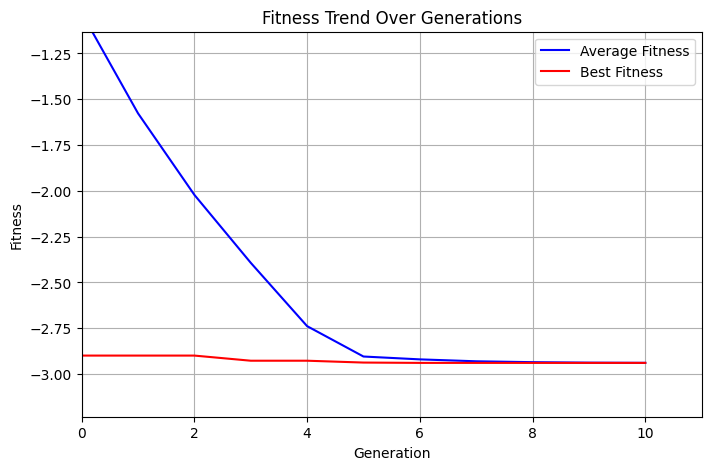

In [239]:
# --- Run GA with custom bounds and step sizes ---
ga = GeneticAlgorithmDEAP(
    surface, 
    bounds=xy_bounds, 
    step_sizes=step_sizes,
    cxpb=0.5, 
    mutpb=0.2, 
    seed=42
)
best = ga.run()
print("Best solution (global minima found):", best)
print("Function value at best solution:", surface.evaluate_point(best[0], best[1]))
print(f"Converged in {ga.converged_generation} generations.")

# --- Animate population on contour plot ---
ga.animate_population(X, Y, Z, save_path='ga_population_animation.gif')

# --- Animate fitness trend (average and best) ---
ga.animate_fitness_trend(save_path='fitness_trend.gif')